# First steps

In [3]:
#importing
import nltk
import spacy
import warnings
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import en_core_web_sm
from string import punctuation
import matplotlib.pyplot as plt
from skll.metrics import kappa
from tqdm import tqdm_notebook
from sklearn.feature_selection import chi2
from sklearn.decomposition import TruncatedSVD
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, StackingClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, f_regression
warnings.filterwarnings('ignore')
words_english = set(nltk.corpus.words.words())
correct_words_set = set(nltk.corpus.brown.words())
lematizator = en_core_web_sm.load()
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [4]:
# downloading the data
essays = pd.read_csv('data/train_set.csv')
essays_test= pd.read_csv('data/test_set.csv')

In [5]:
essays.head()

,essay_set,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8.0
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,1,"Dear @LOCATION1, I know having computers has a...",8.0


In [6]:
print(essays.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11680 entries, 0 to 11679
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   essay_set      11680 non-null  int64  
 1   essay          11680 non-null  object 
 2   domain1_score  11680 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 273.9+ KB
None


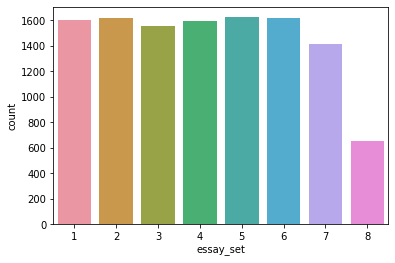

In [7]:
#Topics distribution
sns.countplot(essays['essay_set'])

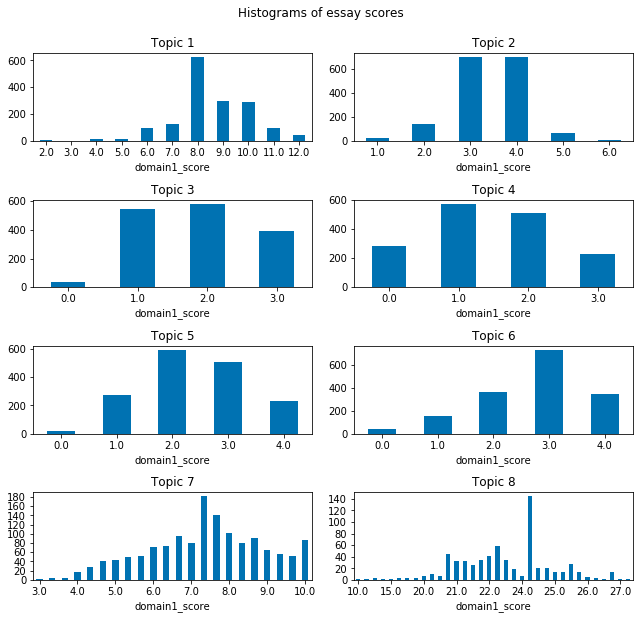

In [8]:
#Scors distribution in each topic
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        essays[essays['essay_set'] == topic_number]\
            .groupby('domain1_score')['essay_set'].agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Feature Engineering

In [9]:
def preprocessing(essays):
    #List of all parts of speech
    list_of_all_tags=['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 
                      'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', 
                      ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', 
                      '.', ',',  '``', '$', 'RB', 'RBR', 'RBS', 'VBD',
                      'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT','MD', 'VB', 
                      'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS']

    # Reseting indexes and lowering all words
    essays['essay'] = essays['essay'].apply(lambda x : x.lower())

    #Splitting essays by sentences and counting them
    nltk_sentences_tokinized = []
    for i in tqdm_notebook(essays['essay']):
        nltk_sentences_tokinized += [nltk.sent_tokenize(i)]
    essays['essay_sentences'] = nltk_sentences_tokinized
    essays['sentences_count'] = essays["essay_sentences"].apply(lambda x:len(x))

    #Removing punctuation and counting words
    nltk_words_tokinized = []
    for i in tqdm_notebook(essays['essay']):
        nltk_words_tokinized += [[word for word in nltk.word_tokenize(i) 
                                  if word not in punctuation]]
    essays['essay_words'] = nltk_words_tokinized
    essays['words_count'] = essays['essay_words'].apply(lambda x:len(x))
    essays['unique_words_count'] = essays['essay_words'].apply(lambda x:len(set(x)))

    #Counting punctuation, spelling errors, charachters
    #Words per sentence ratio, average sentence length
    def words_filter(essays):
        punctuation_count = []
        misspelled_words_count = []
        for essay in tqdm_notebook(essays):
            pc_temp=0
            mw_temp=0
            for word in nltk.word_tokenize(essay):
                if word.lower() not in punctuation:
                    if word.lower() not in correct_words_set:
                        mw_temp+=1
                else:
                    pc_temp+=1
            punctuation_count.append(pc_temp)
            misspelled_words_count.append(mw_temp)
        return punctuation_count,misspelled_words_count
    word_features = words_filter(essays['essay'])
    essays['punctuatioon_count'] = word_features[0]
    essays['spelling_errors'] = word_features[1]
    essays['character_count'] = essays['essay'].apply(lambda essay:len(essay))
    essays['words_per_sent_ratio'] = round(essays['words_count']/essays['sentences_count'])
    essays['avg_sen_len'] = round(essays['character_count']/essays['sentences_count'])

    # Counting only english words
    english_words=[]
    for listofwords in tqdm_notebook(essays['essay_words']):
        temp_english_word=0
        for word in listofwords:
            if word in words_english:
                temp_english_word+=1
        english_words.append(temp_english_word)
    essays['english_words']=english_words

    #Removing only non-stopwords and stopwords
    nltk_words_tokinized_no_stop_words = []
    stopwords_count = []
    for tolinized_list in tqdm_notebook(essays['essay_words']):
        temp_stop_words_count = 0
        temp_nsw = []
        for word in tolinized_list:
            if word not in STOP_WORDS:
                temp_nsw.append(word)
            else:
                temp_stop_words_count+=1
        nltk_words_tokinized_no_stop_words.append(temp_nsw)
        stopwords_count.append(temp_stop_words_count)
    essays['essay_words'] = nltk_words_tokinized_no_stop_words
    essays['stopwords_count'] = stopwords_count

    #Joining essay without stopwords
    def words_joiner(essays):
        for line_number in tqdm_notebook(range(essays.index[0],essays.index[-1]+1)):
            essays['essay_words'][line_number] = ' '.join(essays['essay_words'][line_number])

    #Tagging evry word with the corespondent part of speech
    for i in list_of_all_tags:
        essays[i] = 0
    for line_number in tqdm_notebook(range(essays.index[0],essays.index[-1]+1)):
        temp_pos_list = np.unique(np.array(nltk.pos_tag(essays['essay_words'][line_number]))[:,1], return_counts=True)
        pos_list = list(zip(temp_pos_list[0],temp_pos_list[1]))
        for i in pos_list:
            essays[i[0]][line_number]=i[1]
    essays.drop(columns=["''", '--', ':', '(', ')', '.', ',', '``',
                         '$','essay','essay_sentences'],inplace=True,axis=1)
    words_joiner(essays)

    #Reducing every word to its grammatical root and counting absolute and unique number of those roots
    lemmatized_essay_words = []
    for essay in  tqdm_notebook(essays['essay_words']):
        lemmatized = [t.lemma_ for t in lematizator(essay)]
        lemmatized_essay_words.append(lemmatized)
    essays['essay_words'] = lemmatized_essay_words
    essays['token_count'] = essays['essay_words'].apply(lambda x: len(x))
    essays['unique_token_count'] = essays['essay_words'].apply(lambda x: len(set(x)))
    
    return words_joiner(essays)

In [10]:
#adding all of the features
preprocessing(essays)
preprocessing(essays_test)

In [11]:
essays.head()

,essay_set,domain1_score,sentences_count,essay_words,words_count,unique_words_count,punctuatioon_count,spelling_errors,character_count,words_per_sent_ratio,...,WRB,NNP,EX,NNS,SYM,CC,CD,POS,token_count,unique_token_count
0,1,8.0,16,dear local newspaper think effect computer peo...,343,165,43,28,1875,21.0,...,0,0,0,16,0,0,0,0,160,101
1,1,9.0,20,dear caps1 caps2 believe computer benefit way ...,422,194,42,33,2288,21.0,...,0,0,0,35,0,0,1,0,184,107
2,1,7.0,14,dear caps1 caps2 caps3 people use computer agr...,283,149,30,12,1541,20.0,...,0,0,0,34,0,0,0,0,120,74
3,1,10.0,27,dear local newspaper caps1 find expert compute...,530,253,81,84,3165,20.0,...,0,0,0,51,0,0,0,0,273,158
4,1,8.0,30,dear location1 know have computer positive eff...,470,199,47,30,2569,16.0,...,0,0,0,39,0,0,0,0,182,106


# Modeling and cross-validation

In [12]:
def mean_quadratic_weighted_kappa(kappas, weights):
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])
    
    z = 0.5 * np.log( (1+kappas)/(1-kappas) ) * weights
    z = np.mean(z)
    kappa = (np.exp(2*z)-1) / (np.exp(2*z)+1)
    return kappa

In [13]:
#Feature importances visualization
def feature_importances_visualization(essays,y_train,sel_k_best):
    
    X = essays[essays.drop(['domain1_score','essay_words',
                            'essay_set'],axis=1).columns[(sel_k_best.get_support())]]
    y = y_train.astype(np.float64)
    forest = ExtraTreesClassifier(n_estimators=250, random_state=26)
    forest.fit(X, y)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    features = pd.DataFrame({'feature_name': X.columns, 
                             'importance': forest.feature_importances_, 'std': std})
    features.sort_values('importance').plot.barh(
        x='feature_name', y='importance', xerr='std', legend=False)
    plt.title('Gini importances of forest features')
    plt.xlabel('Gini-importance')
    plt.tight_layout()
    plt.show()

In [14]:
def topics_preprocessing(essays_given,topic,
                         save_to_pkl=False,name_prefix='',feature_importance=True):
    
    essays = essays_given[(essays_given['essay_set']==topic)]
    y_train = essays['domain1_score']
    
    #Vectorization of text data
    tv = TfidfVectorizer(ngram_range=(1, 5), max_features=2000)
    essay_words_vectorized = tv.fit_transform(essays['essay_words'])
    
    #Numerical features selection
    sel_k_best = SelectKBest(chi2, k=15)
    selected_sel_k_best = sel_k_best.fit_transform(
        essays.drop(['domain1_score','essay_words','essay_set'],axis=1),y_train)
    if feature_importance:
        feature_importances_visualization(essays,y_train,sel_k_best)
        
    #Performng num. features scaling, stacking with vectorized text data and dim. red.
    pca = TruncatedSVD(n_components=15,random_state = RANDOM_STATE)
    scaleer = StandardScaler(copy=True, with_mean=True, with_std=True)
    numerical_scaled = scaleer.fit_transform(selected_sel_k_best)
    essay_words_vectorized_reduced = pca.fit_transform(essay_words_vectorized)
    X_reduced = np.concatenate((essay_words_vectorized_reduced,numerical_scaled),axis=1)
    if save_to_pkl:
        pickle.dump(tv,open('./pickles/'+name_prefix+'_vectorizer.pkl','wb'))
        pickle.dump(sel_k_best,open('./pickles/'+name_prefix+'_selector.pkl','wb'))
        pickle.dump(scaleer,open('./pickles/'+name_prefix+'_scaleer.pkl','wb'))
        pickle.dump(pca,open('./pickles/'+name_prefix+'_pca.pkl','wb'))
    return X_reduced, y_train

In [15]:
#All choosen ML models
RANDOM_STATE = 47

log_clf = LogisticRegression(
    penalty='l2',C=5,n_jobs=-1,
    random_state = RANDOM_STATE,max_iter=5000000)

random_forest_clf = RandomForestClassifier(
    n_estimators=70,random_state = RANDOM_STATE, n_jobs=-1)

et_clf = ExtraTreesClassifier(
    n_estimators=70,random_state=RANDOM_STATE, n_jobs=-1)

# Stacking
estimators = [('logistic', log_clf),
              ('ET', et_clf),
              ('rf', random_forest_clf)]

model_stacked_clf=StackingClassifier(
    estimators=estimators, final_estimator=log_clf, 
    stack_method = 'predict_proba', n_jobs=-1, 
    passthrough=False, cv=StratifiedKFold(n_splits=2,random_state = RANDOM_STATE))

In [16]:
#Performing 5 fold cross-validation
kappa_scorer = make_scorer(cohen_kappa_score,weights="quadratic")
kappa_scorer_reg = make_scorer(kappa,weights="quadratic")
splits = StratifiedKFold(n_splits=5,random_state = RANDOM_STATE)
kappas_means = []
weights = []
for i in range(1,9):
    if i == 8:
        model = Ridge()
        scorer = kappa_scorer_reg
    else:
        model = model_stacked_clf
        scorer = kappa_scorer
    X_reduced, y_train = topics_preprocessing(essays,i,feature_importance=False)
    cv_scores_kappa_scorer = cross_val_score(
        model, X_reduced, y_train, cv=splits, scoring=scorer, n_jobs=-1, verbose=0)
    print('Topic',i,'kappa_score:{}'.format(round(cv_scores_kappa_scorer.mean(),2)))
    kappas_means.append(cv_scores_kappa_scorer.mean())
    weights.append(len(X_reduced))
mqwk = mean_quadratic_weighted_kappa(kappas_means, weights=weights)
print('Every topic kappa score')
for i in kappas_means:
    print(i)
print('Weighted by topic Kappa score: {}'.format(round(mqwk,2)))
print('Average Kappa score: {}'.format(round(np.array(kappas_means).mean(),2)))

Topic 1 kappa_score:0.82
Topic 2 kappa_score:0.69
Topic 3 kappa_score:0.71
Topic 4 kappa_score:0.76
Topic 5 kappa_score:0.8
Topic 6 kappa_score:0.74
Topic 7 kappa_score:0.75
Topic 8 kappa_score:0.71
Every topic kappa score
0.8241264607155268
0.6878302038144783
0.705068755782851
0.7643433579842478
0.8037582720184678
0.7423250455292876
0.7536106267222619
0.7069883927302116
Weighted by topic Kappa score: 0.76
Average Kappa score: 0.75


# Testing on a test-set

In [17]:
kappas = []
weights = []
for i in range(1,9):
    if i == 8:
        model = Ridge()
        scorer = kappa
    else:
        model = model_stacked_clf
        scorer = cohen_kappa_score
    X_reduced, y_train = topics_preprocessing(essays,i,feature_importance=False)
    X_reduced_test,y_test = topics_preprocessing(essays_test,i,feature_importance=False)
    model.fit(X_reduced,y_train)
    prediction = model.predict(X_reduced_test)
    score = scorer(y_test,prediction,weights="quadratic")
    print('topic{} '.format(i),round(score,2))
    kappas.append(score)
    weights.append(len(X_reduced))
mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {}'.format(round(mqwk,2)))
print('Average Kappa score: {}'.format(round(np.array(kappas).mean(),2)))

topic1  0.74
topic2  0.49
topic3  0.64
topic4  0.63
topic5  0.78
topic6  0.75
topic7  0.68
topic8  0.6
Weighted by topic Kappa score: 0.68
Average Kappa score: 0.66


# Training on 2 types of essay and saving all vectorizors and the final model

In [18]:
#preprocessing
persuasive_essays = topics_preprocessing(
    essays,1,save_to_pkl=True,name_prefix='persuasive',feature_importance=False)
critical_response_essays = topics_preprocessing(
    essays,5,save_to_pkl=True,name_prefix='critical',feature_importance=False)

#Training the models
model_saving_persuasive = model_stacked_clf
model_saving_persuasive.fit(persuasive_essays[0], persuasive_essays[1])
pickle.dump(model_saving_persuasive,open('pickles/persuasive_model.pkl','wb'))
model_saving_critical = model_stacked_clf
model_saving_critical.fit(critical_response_essays[0], critical_response_essays[1])
pickle.dump(model_saving_critical,open('pickles/critical_model.pkl','wb'))